# Statistical Analysis 


## Load Data

In [1]:
%%capture

import sys
sys.path.append("..")

import mne
from mne.channels import find_ch_adjacency, make_1020_channel_selections
import os
import numpy as np
from scipy import stats 
from mne_bids import BIDSPath, read_raw_bids
from matplotlib import pyplot as plt
from src.utils import load_subject, pipeline
from src.plots import plot_ERPs


# Set BIDS path
bids_path = BIDSPath(root='../data', task='jacobsen', suffix='eeg')

# List of all subject BIDS path
all_sub_paths = bids_path.match()

# Create dictionary to store individual subject ephochs and evoked
sub_epochs = {'regular': [], 'random': []}
sub_evokeds = {'regular': [], 'random': []}

# Subject to exclude from ica
no_ica_sub = ['004', '008', '016', '017', '018']

for sub_path in all_sub_paths:
        # Load data
        raw = load_subject(sub_path)

        if sub_path.subject in no_ica_sub:
            perform_ica = False
        else:
            perform_ica = True

        ## Execute filtering + cleaning data pipeline
        raw, epochs = pipeline(
            raw,
            tmin = -1,
            tmax = 1,
            reject_amp = 100e-6, #±μ100 (if commented out doea not reject components)
            perform_ica = False # ICA doesn't drop any componens
        )

        # Save individual subject epochs and evoked 
        sub_epochs['regular'].append(epochs['regular'])
        sub_epochs['random'].append(epochs['random'])
        sub_evokeds['regular'].append(epochs['regular'].average())
        sub_evokeds['random'].append(epochs['random'].average())

## _t_-Test

In [2]:
diff_waves = []
for i, _ in enumerate(all_sub_paths):
    diff_waves.append(mne.combine_evoked([sub_evokeds['regular'][i], sub_evokeds['random'][i]], weights=[1, -1]))



picks = ["PO3", "PO7", "PO4", "PO8"]

y = np.array([np.mean(e.get_data(picks=picks, tmin=-1, tmax=1),axis=1) for e in diff_waves])

# check shape of result
print('shape: ', y.shape)

# t-Test
t, pval = stats.ttest_1samp(y, 0)
print('Difference t = ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

shape:  (24, 4)
Difference t =  -3.5 p =  0.0019


## Clustering

shape:  (24, 257, 64)
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


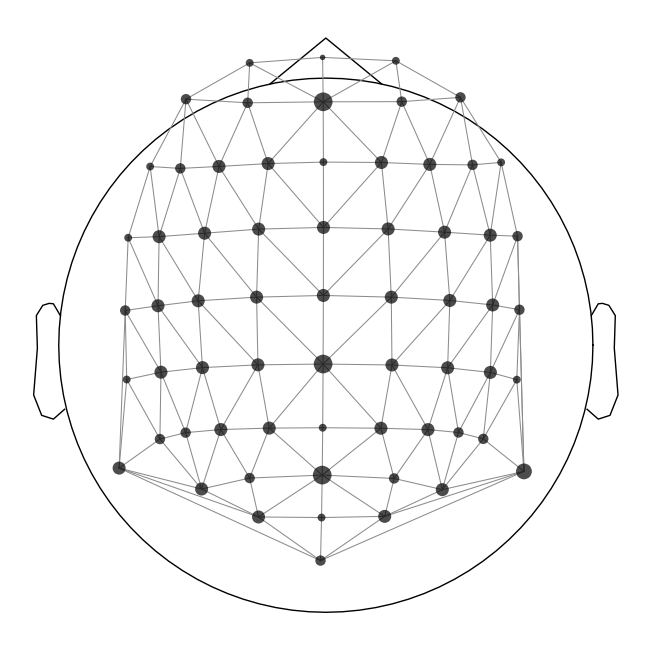

In [3]:
from mne.stats import spatio_temporal_cluster_1samp_test

y = np.swapaxes(np.array([e.get_data() for e in diff_waves] ),1, 2)

# check shape of result
print('shape: ', y.shape)

adjacency, ch_names = find_ch_adjacency(diff_waves[0].info, ch_type='eeg')
mne.viz.plot_ch_adjacency(diff_waves[0].info, adjacency, ch_names=ch_names);

In [4]:
n_perm = 5e4

t_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_1samp_test( 
    y, 
    adjacency=adjacency,
    n_permutations=n_perm, 
    out_type='mask',
    n_jobs=-1, 
    verbose='Info'
    )

Using a threshold of 2.068658
stat_fun(H1): min=-7.591128 max=6.418310
Running initial clustering …
Found 130 clusters


/Users/saponaro/Developer/uni/eeg_penguin/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 49999/49999 [03:41<00:00,  226.22it/s]


In [5]:
# find significant points across all clusters
mask_idx = np.where(cluster_pv < 0.05)[0]
mask = [clusters[idx] for idx in mask_idx]

# stats output is time X chan, but ERP data is chan X time, so transpose
mask = mask[0].T

Identifying common channels ...


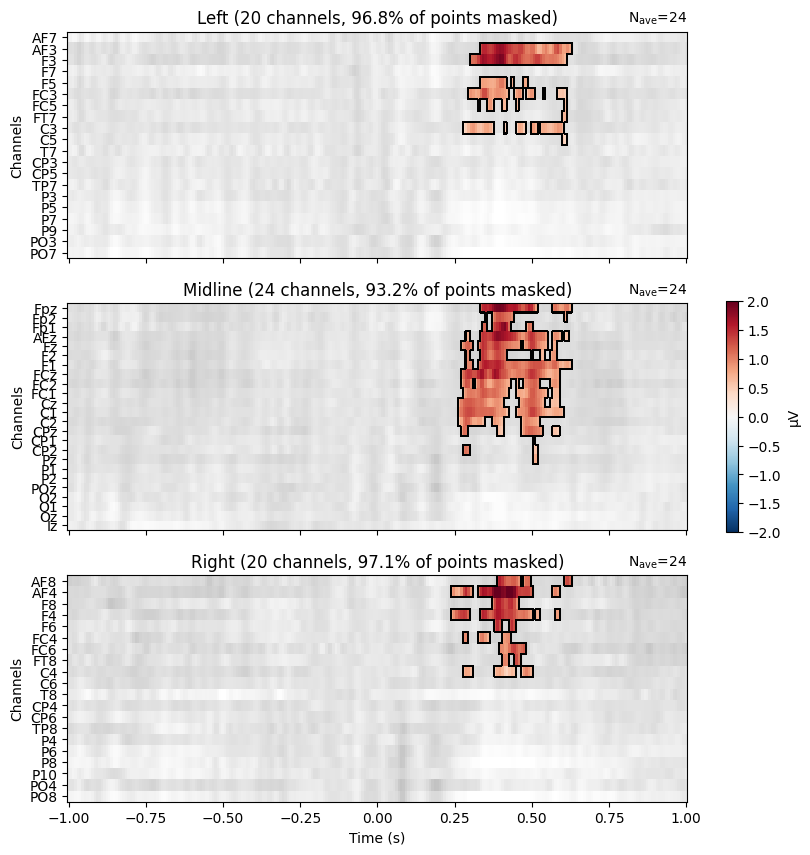

In [6]:
# Create ROIs by checking channel labels
selections = make_1020_channel_selections(diff_waves[0].info, midline="12z")
time_unit = dict(time_unit="s")

fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
mne.grand_average(diff_waves).plot_image(axes=axes,
                            group_by=selections,
                            colorbar=False,
                            show=False,
                            mask=mask,
                            show_names="all",
                            titles=None,
                            **time_unit,
                            clim = dict(eeg=[-2, 2])
                            )
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")

plt.show()

Identifying common channels ...


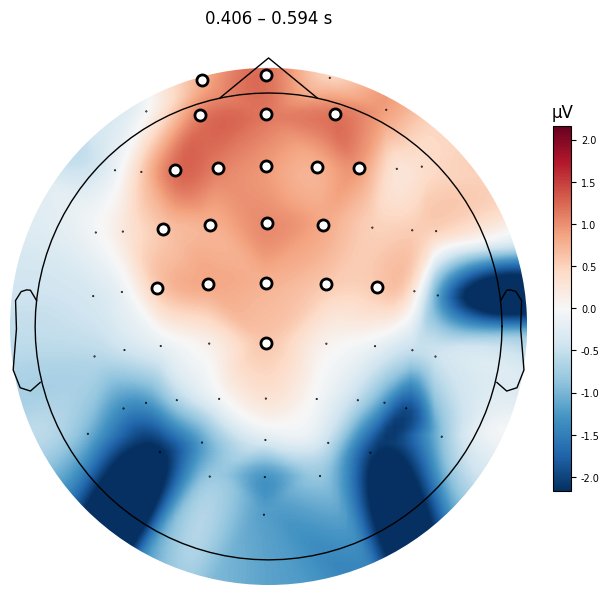

In [7]:
mne.grand_average(diff_waves).plot_topomap(times=0.5,
                                             average=0.200,
                                             mask=mask,
                                             contours=False,
                                             sensors=True,
                                             size=4
                                            );

### TFCE

In [8]:
n_perm = 5e3
threshold_tfce = dict(start=0, step=0.2)

t_tfce, clusters_tfce, cluster_pv_tfce, H0_tfce = spatio_temporal_cluster_1samp_test( 
    y, 
    threshold=threshold_tfce,
    adjacency=adjacency,
    n_permutations=n_perm, 
    out_type='mask',
    n_jobs=-1, 
    verbose='Info'
    )

stat_fun(H1): min=-7.591128 max=6.418310
Running initial clustering …
Using 38 thresholds from 0.00 to 7.40 for TFCE computation (h_power=2.00, e_power=0.50)
Found 16448 clusters


100%|██████████| Permuting : 4999/4999 [33:41<00:00,    2.47it/s]


Identifying common channels ...


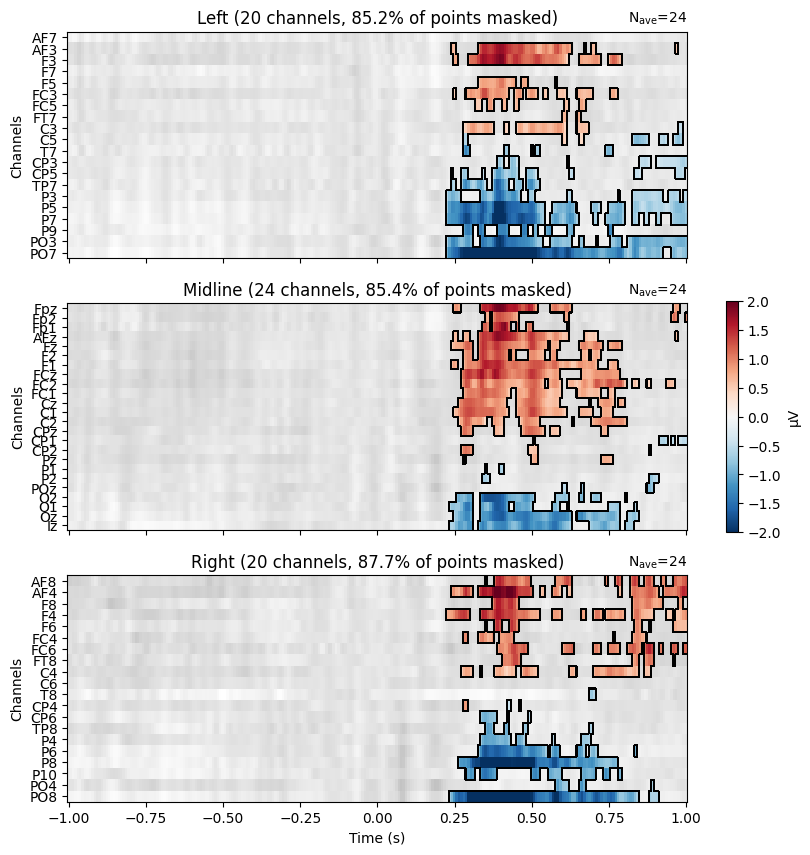

In [9]:
# stats output is time X chan, but ERP data is chan X time, so transpose
mask = cluster_pv_tfce.reshape(t_tfce.shape).T < .05

fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
mne.grand_average(diff_waves).plot_image(axes=axes,
                            group_by=selections,
                            colorbar=False,
                            show=False,
                            mask=mask,
                            show_names="all",
                            titles=None,
                            **time_unit,
                            clim = dict(eeg=[-2, 2])
                            )
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")

plt.show()

Identifying common channels ...


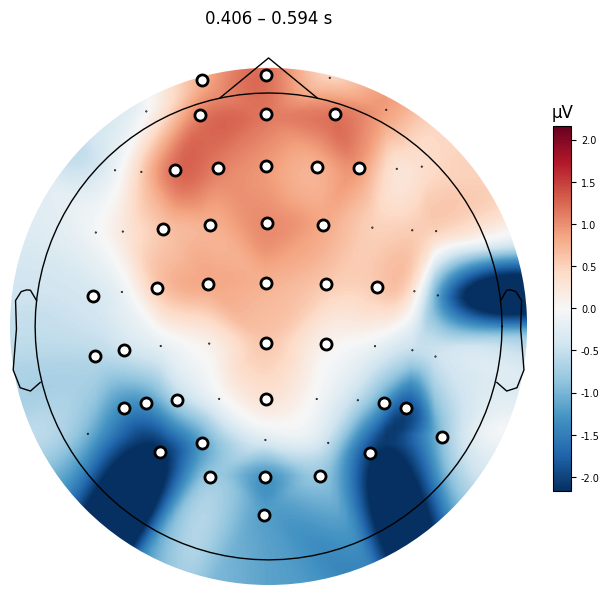

In [10]:
mne.grand_average(diff_waves).plot_topomap(times=.500,
                                             average=0.200,
                                             mask=mask,
                                             contours=False,
                                             sensors=True,
                                             size=4
                                            );